Using TensorFlow backend.


(17543, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 2)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 24, 32)       2432        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 24, 128)      34304       input_1[0][0]                    
__________________________________________________________________________________________________
bidir

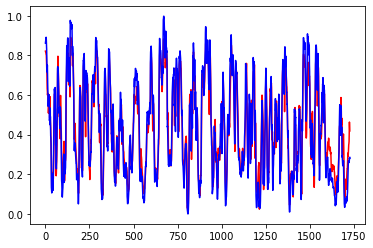

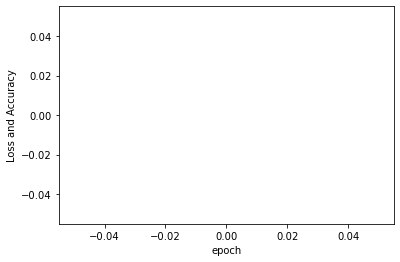

Test Score > MSE ==  0.005675643603730331  MAE ==  0.05837249675980388 MAPE ==  inf


C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide


In [1]:
import pandas as pd
import tensorflow as tf
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import merge
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Add
from keras.layers import Activation, BatchNormalization
# regularizers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import LSTM, Bidirectional
from keras.utils import plot_model
from keras.layers import Dropout
from scipy import signal
import openpyxl

class LossHistory(keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def create_dataset(dataset, timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps - 1):
        a = dataset[i:(i + timesteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + timesteps, 0])
    return np.array(dataX), np.array(dataY)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

data_path = 'C:/Users/Smartgrid_ML/Desktop/KMS/ercot_2016.xlsx'
data_source = pd.read_excel(data_path, sheet_name='numbers')
data_source = pd.DataFrame(data_source)
data_set = data_source.iloc[:, 3]
wind_2016 = np.array(data_set)
wind_2016 = wind_2016.reshape(-1, 1)
installed_2016 = data_source.iloc[:, 4]
installed_2016 = np.array(installed_2016)
installed_2016 = installed_2016.reshape(-1, 1)

data_path = 'C:/Users/Smartgrid_ML/Desktop/KMS/ercot_2017.xlsx'
data_source = pd.read_excel(data_path, sheet_name='numbers')
data_source = pd.DataFrame(data_source)
data_set = data_source.iloc[:, 3]
wind_2017 = np.array(data_set)
wind_2017 = wind_2017.reshape(-1, 1)
installed_2017 = data_source.iloc[:, 4]
installed_2017 = np.array(installed_2017)
installed_2017 = installed_2017.reshape(-1, 1)

wind = np.concatenate((wind_2016, wind_2017), axis=None)
wind = wind.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
wind = scaler.fit_transform(wind)
Maxvalue_1 = scaler.data_max_

data_path = 'C:/Users/Smartgrid_ML/Desktop/KMS/ERCOT_wind_201617.csv'
data_source = pd.read_csv(data_path, low_memory=False)
data_source = pd.DataFrame(data_source)

cap = data_source.iloc[0,2:]
cap = np.array(cap)
cap = cap.reshape(1,-1)
data_set = data_source.iloc[1:,2:]
data_set = np.array(data_set)
ws_data = np.zeros((len(data_set)-1,1))

for i in range(140):
    for j in range(len(data_set)-1):
        data_set[j,i] = data_set[j,i]/cap[0,i]

for i in range(len(data_set)-1):
    ws_data[i,0] = np.sum(data_set[i,:])

print(ws_data.shape)

wind_tr = wind[0:10525, :]
wind_val = wind[10526:15789, :]
wind_te = wind[15790:17543:, :]
ws_tr = ws_data[0:10525, :]
ws_val = ws_data[10526:15789, :]
ws_te = ws_data[15790:17543:, :]

features = 2
timesteps = 24
w_trX, w_trY = create_dataset(wind_tr, timesteps)
w_valX, w_valY = create_dataset(wind_val, timesteps)
w_teX, w_teY = create_dataset(wind_te, timesteps)
ws_trX, ws_trY = create_dataset(ws_tr, timesteps)
ws_valX, ws_valY = create_dataset(ws_val, timesteps)
ws_teX, ws_teY = create_dataset(ws_te, timesteps)

w_trX = np.reshape(w_trX, (w_trX.shape[0], w_trX.shape[1], 1))
w_valX = np.reshape(w_valX, (w_valX.shape[0], w_valX.shape[1], 1))
w_teX = np.reshape(w_teX, (w_teX.shape[0], w_teX.shape[1], 1))
ws_trX = np.reshape(ws_trX, (ws_trX.shape[0], ws_trX.shape[1], 1))
ws_valX = np.reshape(ws_valX, (ws_valX.shape[0], ws_valX.shape[1], 1))
ws_teX = np.reshape(ws_teX, (ws_teX.shape[0], ws_teX.shape[1], 1))

trainX = np.dstack((w_trX, ws_trX))
validX = np.dstack((w_valX, ws_valX))
testX = np.dstack((w_teX, ws_teX))
trainY = w_trY
validY = w_valY
testY = w_teY


import keras.backend.tensorflow_backend as K
with K.tf.device('/gpu:0'):
    visible1 = Input(shape=(timesteps, features))
    con10 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(visible1)
    con10 = Activation('selu')(con10)

    bi11 = (Bidirectional(LSTM(16, return_sequences=True)))(visible1)
    bi12 = (Bidirectional(LSTM(16, return_sequences=True)))(bi11)
    con11 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(bi12)
    con11 = Activation('selu')(con11)
    res13 = keras.layers.Concatenate()([bi12, con11, visible1])
    con20 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(res13)
    con20 = Activation('selu')(con20)

    bi211 = (Bidirectional(LSTM(64, return_sequences=True)))(visible1)
    bi212 = (Bidirectional(LSTM(64, return_sequences=True)))(bi211)
    con211 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(bi212)
    con211 = Activation('selu')(con211)
    res213 = keras.layers.Concatenate()([bi212, con211, visible1])
    con220 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(res213)
    con220 = Activation('selu')(con220)

    fus1 = keras.layers.Concatenate()([res13, res213])

    bi13 = (Bidirectional(LSTM(16, return_sequences=True)))(fus1)
    bi14 = (Bidirectional(LSTM(16, return_sequences=True)))(bi13)
    con12 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(bi14)
    con12 = Activation('selu')(con12)
    res14 = keras.layers.Concatenate()([res13, bi14, con12, visible1])
    con21 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(res14)
    con21 = Activation('selu')(con21)

    bi213 = (Bidirectional(LSTM(64, return_sequences=True)))(fus1)
    bi214 = (Bidirectional(LSTM(64, return_sequences=True)))(bi213)
    con212 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(bi214)
    con212 = Activation('selu')(con212)
    res214 = keras.layers.Concatenate()([res213, bi214, con212, visible1])
    con221 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(res214)
    con221 = Activation('selu')(con221)

    fus2 = keras.layers.Concatenate()([res14, res214])

    bi15 = (Bidirectional(LSTM(16, return_sequences=True)))(fus2)
    bi16 = (Bidirectional(LSTM(16, return_sequences=True)))(bi15)
    con13 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(bi16)
    con13 = Activation('selu')(con13)
    res15 = keras.layers.Concatenate()([res14, bi16, con13, visible1])
    con22 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(res15)
    con22 = Activation('selu')(con22)

    bi215 = (Bidirectional(LSTM(64, return_sequences=True)))(fus2)
    bi216 = (Bidirectional(LSTM(64, return_sequences=True)))(bi215)
    con213 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(bi216)
    con213 = Activation('selu')(con213)
    res215 = keras.layers.Concatenate()([res214, bi216, con213, visible1])
    con222 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(res215)
    con222 = Activation('selu')(con222)

    fus3 = keras.layers.Concatenate()([res15, res215])

    bi17 = (Bidirectional(LSTM(16, return_sequences=True)))(fus3)
    bi18 = (Bidirectional(LSTM(16, return_sequences=True)))(bi17)
    con14 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(bi18)
    con14 = Activation('selu')(con14)
    res16 = keras.layers.Concatenate()([res15, bi18, con14, visible1])
    con23 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(res16)
    con23 = Activation('selu')(con23)

    bi217 = (Bidirectional(LSTM(64, return_sequences=True)))(fus3)
    bi218 = (Bidirectional(LSTM(64, return_sequences=True)))(bi217)
    con214 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(bi218)
    con214 = Activation('selu')(con214)
    res216 = keras.layers.Concatenate()([res215, bi218, con214, visible1])
    con223 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(res216)
    con223 = Activation('selu')(con223)

    fus4 = keras.layers.Concatenate()([res16, res216])

    bi19 = (Bidirectional(LSTM(16, return_sequences=True)))(fus4)
    bi20 = (Bidirectional(LSTM(16, return_sequences=True)))(bi19)
    con15 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(bi20)
    con15 = Activation('selu')(con15)
    res17 = keras.layers.Concatenate()([res16, bi20, con15, visible1])

    bi219 = (Bidirectional(LSTM(64, return_sequences=True)))(fus4)
    bi220 = (Bidirectional(LSTM(64, return_sequences=True)))(bi219)
    con215 = Conv1D(filters=128, kernel_size=1, strides=1, padding='same')(bi220)
    con215 = Activation('selu')(con215)
    res217 = keras.layers.Concatenate()([res216, bi220, con215, visible1])

    addi = keras.layers.Concatenate()([res17, res217])

    bi21 = (Bidirectional(LSTM(128)))(addi)

    dense11 = Dense(24, activation='selu')(bi21)
    out1 = Dense(1, activation='selu')(dense11)

    model = Model(inputs=[visible1], outputs=[out1])  # multi-input, multi-output
#########################################

print(model.summary())

reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)  # 에포크 1동안 좋아지지 않으면 호출

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

batch_size = 40
epochs = 20

history = LossHistory()
history.init()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(validX, validY), callbacks=[history, reducelr])  # , checkpoint

trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
validPredict = model.predict(validX, batch_size=batch_size)
trainPredict = trainPredict.reshape([-1])
testPredict = testPredict.reshape([-1])
validPredict = validPredict.reshape([-1])
testY = testY.reshape([-1])
trainY = trainY.reshape([-1])
validY = validY.reshape([-1])

np.savetxt('Predict_weather_withoutAttention.txt', testPredict)

print('--------------------------------------------------------')
print(' history.mses(=loss) = ', history.mses)  # loss == mse
print(' history.maes        = ', history.maes)
print(' history.mapes        = ', history.mapes)
print(' history.val_mses(=loss)= ', history.val_mses)  # loss == mse
print(' history.val_maes       = ', history.val_maes)
print(' history.val_mapes       = ', history.val_mapes)
print('--------------------------------------------------------')

plt.figure(1)
plt.plot(testPredict, 'r')
plt.plot(testY, 'b')
plt.show()

plt.figure(2)
plt.plot(history.mses, 'b--')
plt.plot(history.val_mses, 'b:')
plt.plot(history.maes, 'ro')
plt.plot(history.val_maes, 'r+')
plt.ylabel('Loss and Accuracy')
plt.xlabel('epoch')
plt.show()

print('Test Score > MSE == ', mean_squared_error(testY, testPredict), ' MAE == ', mean_absolute_error(testY, testPredict), 'MAPE == ', mean_absolute_percentage_error(testY, testPredict))